In [15]:
library(performance)
library(ggplot2)
library(dplyr)
library(rstatix)
library(ggpubr)
library(cluster)


# Reading Data

In [2]:
df<-read.csv("03_Reponse_Grouping_HAI_MSD/lm_res.csv")

In [3]:
table(df$cohort.cohortGuid,df$Assay,df$Flu_Year)

, ,  = 2020-2021

     
      A/Cambodia A/Guangdong Flu B/Phuket HA Flu B/Washington HA
  BR1          0          43              43                  43
  BR2          0          45              45                  45

, ,  = 2021-2022

     
      A/Cambodia A/Guangdong Flu B/Phuket HA Flu B/Washington HA
  BR1         24           0              24                  24
  BR2         42           0              42                  42


In [4]:
HAI<-read.csv("03_Reponse_Grouping_HAI_MSD/HAI_Plotting.csv")

In [5]:
HAI_subet<-HAI %>% filter(Assay=="Flu B/Phuket HA",Flu_Year=="2020-2021")

In [6]:
HAI_subet<-left_join(HAI_subet,df,by=c("subjectGuid","Assay","Flu_Year"))

In [7]:
HAI_subet$Group <- paste0(HAI_subet$`Age.Group`, "_", HAI_subet$Flu_Day)

HAI_subet$Group <- factor(HAI_subet$Group, levels = c(
    "Young_Day_0", "Young_Day_7", "Young_Day_90", 
    "Older_Day_0", "Older_Day_7","Older_Day_90"))

In [8]:
df_max <- HAI_subet %>%
    arrange(responder) %>%
    group_by(Flu_Year) %>%
    summarise(max_overall = max(Adjusted_HAI.Mean_Perc_Inhib), .groups = "drop")

In [9]:
HAI_subet <-HAI_subet %>% mutate(responder=case_when(responder=="low responder"~"Lower Responder",
                                                   responder=="high responder"~"Higher Responder",
                                                   TRUE~"Middle Responder"))
HAI_subet$responder <- factor(HAI_subet$responder, levels = c("Lower Responder","Middle Responder", "Higher Responder"))

In [10]:

create_comp <- function(groups, multiplier, paired,df) {
    res <- if (paired) {
        compare_means(Adjusted_HAI.Mean_Perc_Inhib ~ Group, data = df %>%
            filter(Group %in% groups) %>%
            arrange(subjectGuid, Group), method = "wilcox.test", paired = TRUE, paired_by = "subject.subjectGuid", comparisons = list(groups), group.by = c(
            "responder","Flu_Year"))
    } else {
        compare_means(Adjusted_HAI.Mean_Perc_Inhib ~ Group, data = df %>%
            filter(Group %in% groups) %>%
            arrange(subjectGuid, Group), method = "wilcox.test", paired = FALSE, comparisons = list(groups), group.by = c("responder", "Flu_Year"))
    }

    res %>%
        left_join(df_max ) %>%
        mutate(y.position = max_overall * multiplier)
}

In [11]:
comp_list <- list(
    create_comp(c("Older_Day_0", "Older_Day_7"), 1.05, TRUE,df=HAI_subet), 
    create_comp(c("Young_Day_0", "Young_Day_7"), 1.05, TRUE,df=HAI_subet)
)

comp_all <- bind_rows(comp_list)

Joining with `by = join_by(Flu_Year)`
Joining with `by = join_by(Flu_Year)`


In [14]:
write.csv(HAI_subet %>% select(subjectGuid,
                               Flu_Day,
                               `Age.Group`,
                               Group,
                               Adjusted_HAI.Mean_Perc_Inhib) ,
          "/home/workspace/Source_Data/Fig4d.csv", row.names=FALSE)

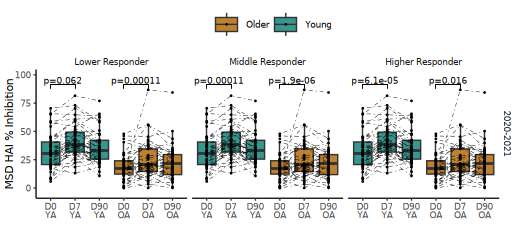

In [13]:
comp_all$p.label <- paste0("p=", comp_all$p.format)
comp_all <- comp_all %>%
  mutate(
    p.label = paste0("p=", signif(p, 2))
  )

p <- ggplot(HAI_subet %>%
    arrange(subjectGuid, Flu_Day), aes(x = Group, y = Adjusted_HAI.Mean_Perc_Inhib, fill = `Age.Group`)) +
    geom_boxplot(outlier.shape = NA, lwd = 0.3) +
    geom_point(color = "black", size = 0.5, stroke = 0) +
    theme_classic(base_size = 6) +
    scale_fill_manual(values = c(Older = "#bf812d", 
                                 Young = "#35978f")) +
    scale_y_continuous(expand = expansion(mult = c(0.1, 0.15))) +
    xlab("") +
    ylab("MSD HAI % Inhibition") +
    scale_x_discrete(labels = c(
        Older_Day_0 = "D0\nOA",
        Older_Day_7 = "D7\nOA", 
        Older_Day_90 = "D90\nOA", 
        Young_Day_0 = "D0\nYA", 
        Young_Day_7 = "D7\nYA", 
        Young_Day_90 = "D90\nYA"
    )) +
    theme(
        legend.position = "top", legend.title = element_blank(), axis.line = element_line(colour = "black"), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.border = element_blank(), panel.background = element_blank(), 
        strip.background = element_rect(linewidth = 0), 
        axis.title.x = element_text(margin = margin(t = 1))
    ) +
    geom_line(aes(group = interaction(`Age.Group`, subjectGuid)), color = "black", linewidth = 0.1, linetype = 4) +
    facet_grid(Flu_Year ~ responder) +
    stat_pvalue_manual(comp_all, label = "p.label", 
                       size = 1.76, bracket.size = 0.2,
                       inherit.aes = FALSE)

options(repr.plot.width = 110/25.4, repr.plot.height = 50/25.4)

p

ggsave('FigureD.pdf', p, width = 115/25.4, height = 50/25.4)

In [134]:

create_comp <- function(groups, multiplier, paired,df) {
    res <- if (paired) {
        compare_means(DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib ~ Group, data = df %>%
            filter(Group %in% groups) %>%
            arrange(subjectGuid, Group), method = "wilcox.test", paired = TRUE, paired_by = "subject.subjectGuid", comparisons = list(groups), group.by = c(
            "responder","Flu_Year"))
    } else {
        compare_means(DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib ~ Group, data = df %>%
            filter(Group %in% groups) %>%
            arrange(subjectGuid, Group), method = "wilcox.test", paired = FALSE, comparisons = list(groups), group.by = c("responder", "Flu_Year"))
    }

    res %>%
        left_join(df_max ) %>%
        mutate(y.position = max_overall * multiplier)
}

comp_list <- list(
    create_comp(c("Older_Day_7","Young_Day_7"),  1.48, FALSE,df=HAI_subet), 
    create_comp(c("Older_Day_0", "Young_Day_0"), 1.35, FALSE,df=HAI_subet), 
    create_comp(c("Older_Day_0", "Older_Day_90"), 1.2, TRUE,df=HAI_subet),
    create_comp(c("Older_Day_7", "Older_Day_90"), 1.05, TRUE,df=HAI_subet), 
    create_comp(c("Young_Day_0", "Young_Day_90"), 1.2, TRUE,df=HAI_subet), 
    create_comp(c("Young_Day_7", "Young_Day_90"), 1.05, TRUE,df=HAI_subet)
)

comp_all <- bind_rows(comp_list)

Joining with `by = join_by(Flu_Year)`
Joining with `by = join_by(Flu_Year)`
Joining with `by = join_by(Flu_Year)`
Joining with `by = join_by(Flu_Year)`
Joining with `by = join_by(Flu_Year)`
Joining with `by = join_by(Flu_Year)`


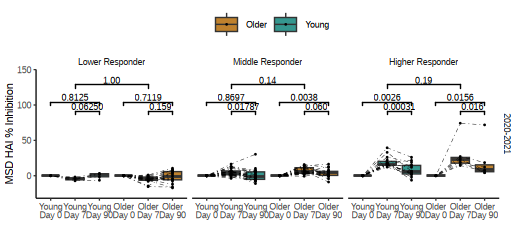

In [110]:
p <- ggplot(HAI_subet %>%
    arrange(subjectGuid, Flu_Day), aes(x = Group, y =DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib	, fill = `Age.Group`)) +
    geom_boxplot(outlier.shape = NA, lwd = 0.3) +
    geom_point(color = "black", size = 0.5, stroke = 0) +
    theme_classic(base_size = 6) +
    scale_fill_manual(values = c(Older = "#bf812d", 
                                 Young = "#35978f")) +
    scale_y_continuous(expand = expansion(mult = c(0.1, 0.15))) +
    xlab("") +
    ylab("MSD HAI % Inhibition") +
    scale_x_discrete(labels = c(
        Older_Day_0 = "Older\nDay 0",
        Older_Day_7 = "Older\nDay 7", 
        Older_Day_90 = "Older\nDay 90", 
        Young_Day_0 = "Young\nDay 0", 
        Young_Day_7 = "Young\nDay 7", 
        Young_Day_90 = "Young\nDay 90"
    )) +
    theme(
        legend.position = "top", legend.title = element_blank(), axis.line = element_line(colour = "black"), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.border = element_blank(), panel.background = element_blank(), 
        strip.background = element_rect(linewidth = 0), 
        axis.title.x = element_text(margin = margin(t = 1))
    ) +
    geom_line(aes(group = interaction(`Age.Group`, subjectGuid)), color = "black", linewidth = 0.1, linetype = 4) +
    facet_grid(Flu_Year ~ responder) +
    stat_pvalue_manual(comp_all, label = "p.format", 
                       size = 1.76, 
                       inherit.aes = FALSE)

options(repr.plot.width = 110/25.4, repr.plot.height = 50/25.4)

p

ggsave('FigureD.pdf', p, width = 115/25.4, height = 50/25.4)